In [65]:
# STANDARD LIBRARIES
import pandas as pd
import numpy as np
import pickle

# VISUALS
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import mglearn

# FEATURE ENGINEERING AND PREPROCESSING
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import NearestNeighbors, NearestCentroid
from sklearn import metrics

# MODELING
from sklearn.cluster import DBSCAN, OPTICS, cluster_optics_dbscan

# METRICS
from sklearn.metrics import silhouette_score
import kneed
from kneed import knee_locator, KneeLocator

%matplotlib inline

# Read Files

In [54]:
main = pd.read_csv("../data/clean-data/main-engineered.csv", low_memory=False)
main.drop(columns="Unnamed: 0", inplace=True)

In [55]:
print(main.shape)
print(main.isna().sum().sum())
main.head()

(97515, 104)
0


zip_street  sum_land_value_street  sum_bldg_value_street  \
0  beacon 02108              188299425             1264932993   
1  beacon 02108              188299425             1264932993   
2  beacon 02108              188299425             1264932993   
3  beacon 02108              188299425             1264932993   
4  beacon 02108              188299425             1264932993   

   sum_total_value_street  sum_gross_tax_street  avg_land_value_street  \
0              1453232418            2540703954          399786.464968   
1              1453232418            2540703954          399786.464968   
2              1453232418            2540703954          399786.464968   
3              1453232418            2540703954          399786.464968   
4              1453232418            2540703954          399786.464968   

   avg_bldg_value_street  avg_total_value_street  avg_gross_tax_street  \
0           2.685633e+06            3.085419e+06          5.394276e+06   
1           2.685633e+06            3.085419e+06          5.394276e+06   
2           2.685633e+06            3.085419e+06          5.394276e+06   
3           2.685633e+06            3.085419e+06          5.394276e+06   
4           2.685633e+06            3.085419e+06          5.394276e+06   

   sum_land_value_zip  ...  avg_fire_content_loss_zip  reason_category  \
0          1429494339  ...                 126.363636              0.0   
1          1429494339  ...                   0.000000              0.0   
2          1429494339  ...                 126.363636              0.0   
3          1429494339  ...                   0.000000              0.0   
4          1429494339  ...                 126.363636              0.0   

   source_category  requests_total_prop  requests_total_street  \
0              0.0                  0.0                    0.0   
1              0.0                  0.0                    0.0   
2              0.0                  0.0                    0.0   
3              0.0                  0.0                    0.0   
4              0.0                  0.0                    0.0   

   requests_total_zip  req_open_status_prop  req_open_status_street  \
0                 0.0                   0.0                     0.0   
1                 0.0                   0.0                     0.0   
2                 0.0                   0.0                     0.0   
3                 0.0                   0.0                     0.0   
4                 0.0                   0.0                     0.0   

   req_open_status_zip  label_zip  
0                  0.0          1  
1                  0.0          1  
2                  0.0          1  
3                  0.0          1  
4                  0.0          1  

[5 rows x 104 columns]

In [57]:
main["label_zip"].nunique()

34

# Features and Preprocessing

In [66]:
#=============================================================
X = main.drop(columns=[
    "label_zip",
    "zip_street"
])
y = main["label_zip"]

#=============================================================
# CLUSTER ON THE ENTIRE DF
# Z = main.drop(columns=[
#     "label_zip",
#     "label_street",
#     "zipcode",
#     "zip_street",
#     "zip_num_street"
# ])
ss = StandardScaler()
Z = ss.fit_transform(X)
# NORMALIZE TO FOLLOW A GAUSSIAN DIST
Z = normalize(Z)

#=============================================================

# CREATE SUBSET GROUPS TO CLUSTER ON
# prop_cols = [col for col in main.columns if "pw_" in col]
pw_cols = [col for col in main.columns if "pw_" in col]
fire_cols = [col for col in main.columns if "fire_" in col]
req_cols = [col for col in main.columns if "req_" in col]
#=============================================================

# PW VIOLATIONS
Z_pw = main[pw_cols].copy()
Z_pw["label_zip"] = main["label_zip"].copy()
    
ss = StandardScaler()
Z_pw = ss.fit_transform(Z_pw)
#=============================================================

# FIRE INCIDENTS 
Z_fire= main[fire_cols].copy()
Z_fire["label_zip"] = main["label_zip"].copy()
    
ss = StandardScaler()
Z_fire= ss.fit_transform(Z_fire)
#=============================================================

# Functions

In [61]:
def nearest_nb(x):
    nb = NearestNeighbors(n_neighbors=5, algorithm="auto", metric="euclidean").fit(x)
    distances, indices = nb.kneighbors(x)
    
    return distances, indices
# https://stackoverflow.com/questions/51305370/calculating-average-distance-of-nearest-neighbours-in-pandas-dataframe

# DBSCAN

**Limitations**

Implicit assumptions in this approach:

- Densities across all the clusters are the same.
- Cluster sizes or standard deviations are the same.

## Main

**Distance**

(97515, 5)
0.0


<Figure size 2160x1440 with 0 Axes>

<Figure size 360x360 with 0 Axes>

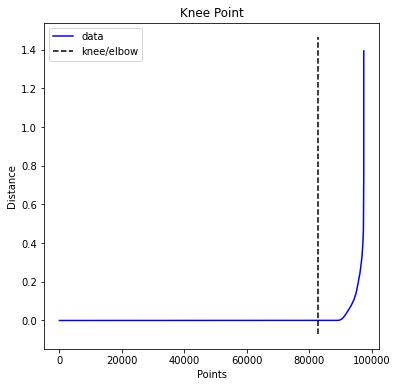

In [68]:
# COMMENT/UNCOMMENT OUT FOR DISTANCES
#=========================
# CALL FUNCTION TO FIND NEAREST NEIGHBORS (nearest_nb)
distances_main, indices_main = nearest_nb(Z)

#=========================
# SAVE THE DISTANCES AND INDICES
#=========================
filename = "../assets/variables/main-nb-distances"
outfile = open(filename, "wb")
pickle.dump(distances_main, outfile)
outfile.close()

filename = "../assets/variables/main-nb-indices"
outfile = open(filename, "wb")
pickle.dump(indices_main, outfile)
outfile.close()
#=========================

# READ IN THE DISTANCE AND INDICES FILES SAVED ABOVE
# distances_main = pd.read_pickle("../assets/variables/main-nb-distances")

# indices_main = pd.read_pickle("../assets/variables/main-nb-indices")
#=========================

# PRINT SHAPE OF DISTANCES
print(distances_main.shape)

distances_main = np.sort(distances_main, axis=0)
# BELOW SHOULD BE RAN ONLY ONCE, COMMENT OUT WHEN RAN THE FIRST TIME
distances_main = distances_main[:, 1]

# plt.figure(figsize=(12, 8))

# plt.plot(distances_main);

# https://towardsdatascience.com/how-to-use-dbscan-effectively-ed212c02e62
# THIS PLOT SHOWS THE POINT OF MAX DISTANCE BETWEEN 2 POINTS
    # IT IS THE POINT OF 'GREATEST DEPARTURE'
plt.figure(figsize=(30, 20))

i = np.arange(len(distances_main))
knee = KneeLocator(i, distances_main, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance");

print(distances_main[knee.knee])

# SAVE THE MAX POINT FOR USE IN DBSCAN CLUSTERING
knee_point_main = distances_main[knee.knee]

**DBSCAN**

In [71]:
# RULE OF THUMB: min_samples SHOULD BE SET TO MIN NUM OF FEATURES
# https://towardsdatascience.com/cluster-analysis-create-visualize-and-interpret-customer-segments-474e55d00ebb

# Provide a value for epsilon which defines the maximum distance between two points
# Find a suitable value for epsilon by calculating the distance to 
    # the nearest n points for each point, sorting and plotting the results
# https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

#==========================
# CLUSTER ON THE ENTIRE MAIN DF
dbscan = DBSCAN(eps=0.5,
                min_samples=main.shape[1])
dbscan.fit(Z)
#==========================
# SAVE FITTED MAIN - DBSCAN
filename = "../assets/models/dbscan-fitted"
outfile = open(filename, "wb")
pickle.dump(dbscan, outfile)
outfile.close()
#==========================
# READ IN THE FITTED DBSCAN FILE
db = pd.read_pickle("../assets/models/dbscan-fitted")
#==========================

**Visualize DBSCAN**

[42 42 42 42 42 42 42 42 42 42]
Estimated number of clusters: 46
Estimated number of noise points: 2718
Homogeneity: 0.888
Completeness: 0.806
V-measure: 0.845
Adjusted Rand Index: 0.785
Adjusted Mutual Information: 0.845
Silhouette Coefficient: 0.090


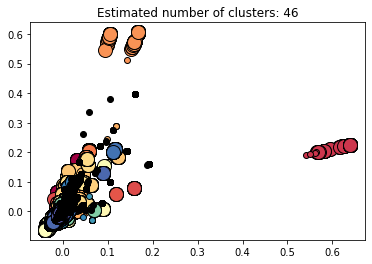

In [74]:
# The labels_ property contains the list of clusters and their respective points.
labels = db.labels_
print(labels[91_000:91_010])

# db = dbscan
labels_true = y

# https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# CAN ALSO USE X_train.iloc[:,:]
# X = np.array(X)

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = Z[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = Z[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [84]:
unique_labels = set(labels)

main["clusters"] = labels

In [90]:
# HOW ARE EACH OF THESE SIMILAR TO EACH OTHER, INTRA CLUSTER?
# ARE THESE GROUPED BY ZIP?
main.loc[main["clusters"] == -1]
main.loc[main["clusters"] == -1]["label_zip"].value_counts()

18    276
21    192
31    186
14    176
11    153
9     152
27    150
26    138
19    135
20    133
15    127
16    101
10     96
8      92
25     91
17     72
13     70
2      66
6      63
22     59
23     58
12     49
7      29
4      24
1      11
3       7
30      7
34      3
24      1
28      1
Name: label_zip, dtype: int64

# OPTICS

## Main

In [ ]:
print(Z_fire.shape)
Z_fire = Z_fire[:1_000]

In [ ]:
opt = OPTICS()
opt.fit(Z_fire)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 97515 but corresponding boolean dimension is 1000

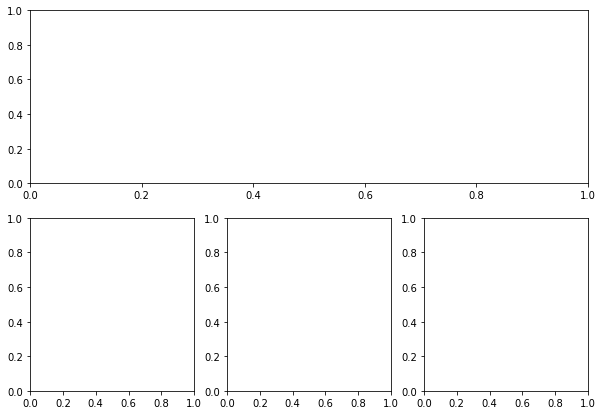

In [67]:
#===================================================
# https://scikit-learn.org/stable/auto_examples/cluster/plot_optics.html#sphx-glr-auto-examples-cluster-plot-optics-py
labels_050 = cluster_optics_dbscan(reachability=opt.reachability_,
                                   core_distances=opt.core_distances_,
                                   ordering=opt.ordering_, eps=0.5)
labels_200 = cluster_optics_dbscan(reachability=opt.reachability_,
                                   core_distances=opt.core_distances_,
                                   ordering=opt.ordering_, eps=2)
space = np.arange(len(Z_fire))
reachability = opt.reachability_[opt.ordering_]
labels = opt.labels_[opt.ordering_]

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

#===================================================
# Reachability plot
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
ax1.plot(space, np.full_like(space, 2., dtype=float), 'k-', alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), 'k-.', alpha=0.5)
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Reachability Plot')

#===================================================

# OPTICS
# colors = ['g.', 'r.', 'b.', 'y.', 'c.']
# for klass, color in zip(range(0, 5), colors):
#     Xk = Z_fire[opt.labels_ == klass]
#     ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
# ax2.plot(X[opt.labels_ == -1, 0], Z_fire[opt.labels_ == -1, 1], 'k+', alpha=0.1)
# ax2.set_title('Automatic Clustering\nOPTICS')

# PCA

In [ ]:
data_cols = pd.read_pickle("../assets/variables/data_cols")
pw_cols = pd.read_pickle("../assets/variables/pw_cols")
fire_cols = pd.read_pickle("../assets/variables/fire_cols")
requests_cols = pd.read_pickle("../assets/variables/requests_cols")

data_main_df = main[data_cols]
pw_main_df = main[pw_cols]
fire_main_df = main[fire_cols]
requests_main_df = main[requests_cols]

main_scaler = StandardScaler()
data_main_sc = main_scaler.fit_transform(data_main_df)
pw_main_sc = main_scaler.fit_transform(pw_main_df)
fire_main_sc = main_scaler.fit_transform(fire_main_df)
requests_main_sc = main_scaler.fit_transform(requests_main_df)

data_main_sc_df = pd.DataFrame(data_main_sc)
pw_main_sc_df = pd.DataFrame(pw_main_sc)
fire_main_sc_df = pd.DataFrame(fire_main_sc)
requests_main_sc_df = pd.DataFrame(requests_main_sc)

## Data Cols

In [ ]:
pca_data = PCA(n_components=5,
          random_state=42)
pca_data.fit(data_main_sc_df)

var_exp = pca_data.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

print(f"Explained Variance (first 20 components): {np.round(var_exp[:20], 3)}")
print("")
print(f"Cumulative Variance (first 20 components): {np.round(cum_var_exp[:20], 3)}")

## PW Violations Cols

In [ ]:
pca_pw = PCA(n_components=5,
          random_state=42)
pca_pw.fit(pw_main_sc_df)

var_exp = pca_pw.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

print(f"Explained Variance (first 20 components): {np.round(var_exp[:20], 3)}")
print("")
print(f"Cumulative Variance (first 20 components): {np.round(cum_var_exp[:20], 3)}")

## Fire Cols

In [ ]:
pca_fire = PCA(n_components=3,
          random_state=42)
pca_fire.fit(fire_main_sc_df)

var_exp = pca_fire.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

print(f"Explained Variance (first 5 components): {np.round(var_exp[:5], 3)}")
print("")
print(f"Cumulative Variance (first 5 components): {np.round(cum_var_exp[:5], 3)}")

## Requests Cols

In [ ]:
pca_requests = PCA(n_components=5,
          random_state=42)
pca_requests.fit(requests_main_sc_df)

var_exp = pca_requests.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

print(f"Explained Variance (first 20 components): {np.round(var_exp[:20], 3)}")
print("")
print(f"Cumulative Variance (first 20 components): {np.round(cum_var_exp[:20], 3)}")

## Entire Main DataFrame

In [ ]:
# BASIC MOST MODEL
pca_main = PCA(n_components=5,
               random_state=42)
pca_main.fit(X_sc)

var_exp = pca_main.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

print(f"Explained Variance (first 20 components): {np.round(var_exp[:40], 3)}")
print("")
print(f"Cumulative Variance (first 20 components): {np.round(cum_var_exp[:40], 3)}")

## For Supervised Learning Models

In [ ]:
X = main.drop(columns="label")
y = main["label"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    random_state=42)

In [ ]:
ss = StandardScaler()
Z_train =  ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

In [ ]:
pca_pipe = Pipeline([
    ("ss", StandardScaler()),
    ("pca", PCA()),
    ("logreg", LogisticRegression())
])

In [ ]:
pca_pipe.get_params();

In [ ]:
params = {
    "pca__n_components": np.arange(1, 10, 1), # THERE ARE 118 COLUMNS
    "pca__random_state": [41],
    "logreg__penalty": ["l1", "l2"],
    "logreg__C": [0.01, 0.1, 1],
    "logreg__verbose": [100]
}

gs = GridSearchCV(
    pca_pipe,
    params,
    cv=5
)

In [ ]:
Z_train

In [ ]:
gs.fit(Z_train, y_train)

# X

## PW

**Distance**

In [ ]:
# CALL FUNCTION TO FIND NEAREST NEIGHBORS (nearest_nb)
distances_pw, indices_pw = nearest_nb(Z_pw)

# SAVE THE DISTANCES AND INDICES
#=========================
filename = "../assets/variables/pw-nb-distances"
outfile = open(filename, "wb")
pickle.dump(distances_pw, outfile)
outfile.close()

filename = "../assets/variables/pw-nb-indices"
outfile = open(filename, "wb")
pickle.dump(indices_pw, outfile)
outfile.close()
#=========================

# READ IN THE DISTANCE AND INDICES FILES SAVED ABOVE
distances_pw = pd.read_pickle("../assets/variables/pw-nb-distances")

indices_pw = pd.read_pickle("../assets/variables/pw-nb-indices")
#=========================

# PRINT SHAPE OF DISTANCES
print(distances_pw.shape)

distances_pw = np.sort(distances_pw, axis=0)
# BELOW SHOULD BE RAN ONLY ONCE, COMMENT OUT WHEN RAN THE FIRST TIME
distances_pw = distances_pw[:, 1]

# plt.figure(figsize=(12, 8))
# plt.plot(distances_pw);
#=========================

# https://towardsdatascience.com/how-to-use-dbscan-effectively-ed212c02e62
# THIS PLOT SHOWS THE POINT OF MAX DISTANCE BETWEEN 2 POINTS
    # IT IS THE POINT OF 'GREATEST DEPARTURE'
plt.figure(figsize=(30, 20))

i = np.arange(len(distances))
knee = KneeLocator(i, distances_pw, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5));
knee.plot_knee()
plt.xlabel("Points");
plt.ylabel("Distance");

print(distances_pw[knee.knee])

# SAVE THE MAX POINT FOR USE IN DBSCAN CLUSTERING
knee_point_pw = distances_pw[knee.knee]

**DBSCAN**

In [ ]:
# RULE OF THUMB: min_samples SHOULD BE SET TO MIN NUM OF FEATURES

# Provide a value for epsilon which defines the maximum distance between two points
# Find a suitable value for epsilon by calculating the distance to 
    # the nearest n points for each point, sorting and plotting the results

#==========================
# CLUSTER ON PW VIOLATIONS AND ZIP
db_pw = DBSCAN(eps=knee_point_pw,
                min_samples=Z_pw.shape[1])
db_pw.fit(Z_pw)
#==========================
# SAVE FITTED PW - DBSCAN
filename = "../assets/models/dbscan_pw-fitted"
outfile = open(filename, "wb")
pickle.dump(db_pw, outfile)
outfile.close()
#==========================
# READ IN THE FITTED DBSCAN FILE
db_pw = pd.read_pickle("../assets/models/dbscan_pw-fitted")
#==========================

**Visualize**

In [ ]:
# The labels_ property contains the list of clusters and their respective points.
labels = db_pw.labels_
print(labels[91_000:91_010])

labels_true = y

# https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html
core_samples_mask = np.zeros_like(db_pw.labels_, dtype=bool)
core_samples_mask[db_pw.core_sample_indices_] = True
labels = db_pw.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# CAN ALSO USE X_train.iloc[:,:]
# X = np.array(X)

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = np.array(Z_pw)[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:
mglearn.plots.plot_dbscan()

In [ ]:
silhouette_score(Z, clusters)

In [ ]:
clusters[clusters == -1].size

In [ ]:
X["clusters"] = clusters
X["clusters"].value_counts(normalize=True)